In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import pandas as pd
import geopandas as gpd

import pymc3 as pm

import matplotlib.pyplot as plt
import matplotlib as mpl    
mpl.rc('font',family='serif')
import seaborn as sns

import pickle
import time

np.random.seed(24) # 42

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwd

In [2]:
pkl_file = open('cm_hp_mp_mu.pkl', 'rb')
cm_hp_mp_mu = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('cm_hp_trace_mu.pkl', 'rb')
cm_hp_trace_mu = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('cm_mu_list_full.pkl', 'rb')
cm_mu_list = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('cm_var_list_full.pkl', 'rb')
cm_var_list = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('train_df_sce.pkl', 'rb')
df = pickle.load(pkl_file)
pkl_file.close()

df = df.sort_values(['gid','year']) # if you want scatter.
x_new = np.arange(1989,2018,1)

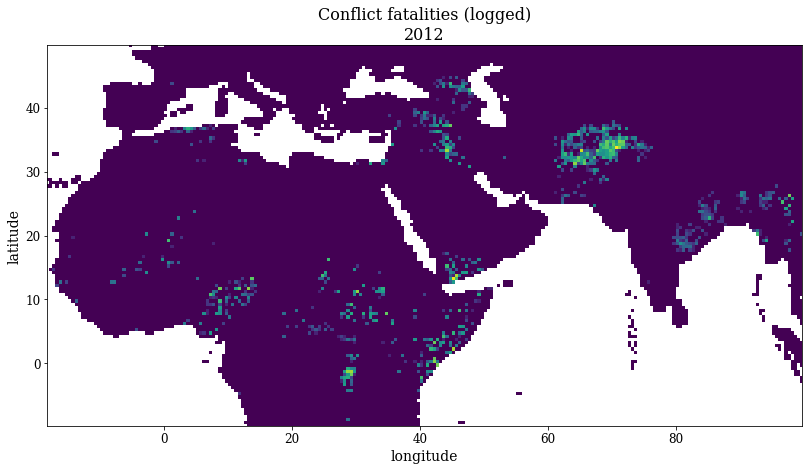

In [3]:
def conflict_plot(df):
    df[df['year']==2012].plot(column = 'log_best', figsize = [13.8,7])
    plt.xlabel('longitude', fontsize = 14)
    plt.ylabel('latitude', fontsize = 14)
    plt.title('Conflict fatalities (logged)\n2012', fontsize = 16)

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

    plt.xlim(df['xcoord'].min(),df['xcoord'].max())
    plt.ylim(df['ycoord'].min(),df['ycoord'].max())

    plt.savefig('log_best_2012_samples.pdf', bbox_inches='tight')

    plt.show()
    
conflict_plot(df)

# CM

In [4]:
def get_events(mu_list, var_list, df):
    mask = np.array(mu_list).all(axis=1)
    events_mu = np.array(mu_list)[mask]
    events_var = np.array(var_list)[mask]
    
    events_gids = df['gid'].unique()[mask]
    

    random_ints = np.random.randint(0,events_mu.shape[0],15)

    sub_events_mu = events_mu[random_ints]
    sub_events_var = events_var[random_ints]
    sub_events_gids = events_gids[random_ints]
    
#     sub_events_df = df[df['gid'].isin(sub_events_gids)].copy()

    return(sub_events_mu, sub_events_var, sub_events_gids)

In [5]:
def plot_samples(mp, mu_list, var_list, df, title, fig_title, ylab, unit):
    
    sub_events_mu, sub_events_var, sub_events_gids = get_events(cm_mu_list, cm_var_list, df)
    
    fig = plt.figure(figsize=(13,5))

    colors = sns.color_palette("hls", 15)

    last_obs = 2012
    X = x_new
    y = sub_events_mu
    y_var = sub_events_var

    for i in np.arange(0,15):
        plt.plot(X,y[i], color = colors[i])
        plt.fill_between(X, y[i] + (y_var[i]*2), y[i] - (y_var[i]*2) , color = colors[i], alpha = 0.1)
        
        
        plt.scatter(X[:X.shape[0]-5],df[df['gid'] == sub_events_gids[i]]['log_best'], color = colors[i], alpha = 0.2, label = '')


    plt.vlines(last_obs,y.min()-1,y.max()*2, linestyles='--', color = 'gray', label='Last observed year = ' + str(last_obs))
    plt.fill_between(X[X>last_obs-1],y.min()-1,y.max()*2, color = 'gray', alpha = 0.1)#, label = '"consultable" forcastings')



    plt.vlines(last_obs +  mp['ℓ'],y.min()-1,y.max()*2, linestyles='-', color = 'salmon', 
               label='Last observed year + $\ell_{%s}$ ≈ %s' % (unit,str(int(last_obs+ mp['ℓ'][0].round(0))))) #old school to accomidate math

    plt.fill_between([last_obs+ mp['ℓ'][0],X.max()],y.min()-1,y.max()*2, color = 'red', alpha = 0.1)#, label = '"unconsultable" forcastings')

    plt.xticks(x_new, rotation=70, fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title(title, fontsize = 16)
    plt.xlabel('year', fontsize = 14)
    plt.ylabel(ylab, fontsize = 14)


    plt.ylim(-1,7)
    plt.xlim(X.min(),X.max())

    plt.legend(fontsize = 12, loc = 0)
        
    #plt.text(1990,6,text, fontsize = 12)
    
    plt.savefig(fig_title + '.pdf', bbox_inches='tight')
    plt.show()



# CM

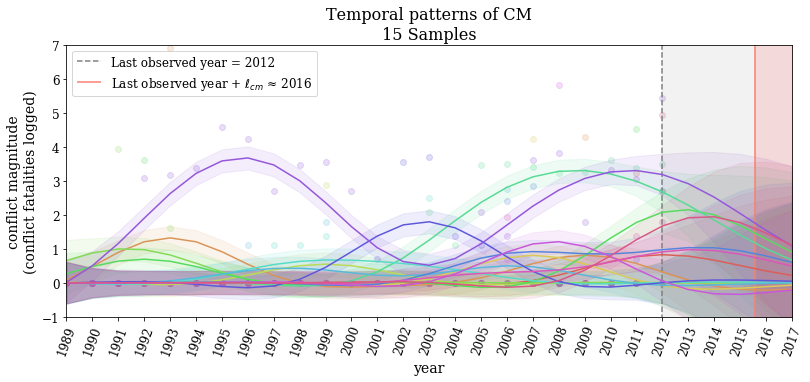

In [6]:
plot_samples(cm_hp_mp_mu, cm_mu_list, cm_var_list, df,'Temporal patterns of CM\n15 Samples', 'cm_15_samples', 'conflict magnitude\n(conflict fatalities logged)','cm')

In [7]:
pm.summary(cm_hp_trace_mu, varnames = ['ℓ','η','σ'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ__0,3.558865,0.236052,0.006610,3.081363,3.991922,1348.303486,1.000681
η__0,1.135721,0.042220,0.000827,1.055965,1.217768,2321.896649,0.999279
σ__0,0.948568,0.017949,0.000450,0.912593,0.982699,1537.916100,1.000170


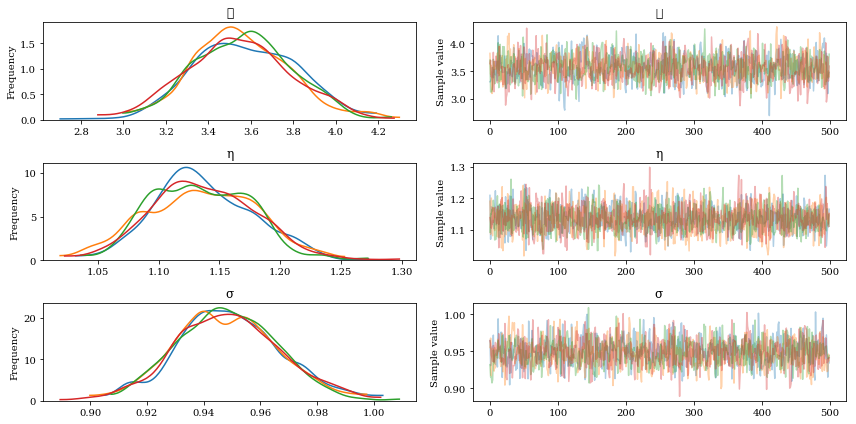

In [8]:
pm.plots.traceplot(cm_hp_trace_mu)
plt.show()

# SCE

In [9]:
pkl_file = open('spatial_trace.pkl', 'rb')

sce_trace = pickle.load(pkl_file)

pkl_file.close()

In [10]:
pm.summary(sce_trace, varnames=['η', 'ℓ', 'σ'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
η__0,0.196058,0.003135,0.000073,0.190021,0.202092,1849.025188,1.000839
ℓ__0,1.325628,0.032640,0.000918,1.261821,1.389521,1373.703987,1.000468
σ__0,0.479795,0.002674,0.000066,0.474506,0.484968,1630.980252,1.002241


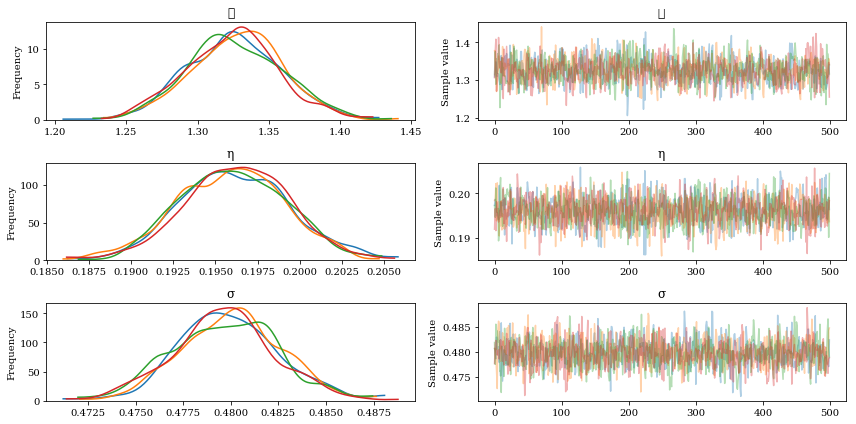

In [11]:
pm.plots.traceplot(sce_trace)
plt.show()

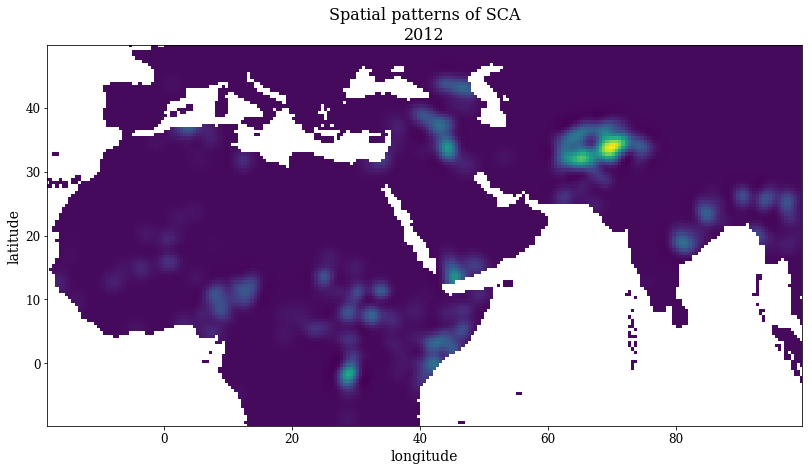

In [12]:
def sce_plot(df):
    df[df['year']==2012].plot(column = 'sce_mu', figsize = [13.8,7])
    plt.xlabel('longitude', fontsize = 14)
    plt.ylabel('latitude', fontsize = 14)
    plt.title('Spatial patterns of SCA\n2012', fontsize = 16)

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

    plt.xlim(df['xcoord'].min(),df['xcoord'].max())
    plt.ylim(df['ycoord'].min(),df['ycoord'].max())

    plt.savefig('sce_2012_samples.pdf', bbox_inches='tight')

    plt.show()
    
sce_plot(df)

In [13]:
# plt.figure(figsize=[13.8,7])

# sub_df = df[df['year']==2012].copy()
# X = np.array([sub_df['xcoord'], sub_df['ycoord']]).T
# plt.scatter(X[:,0], X[:,1], s=6, c =sub_df['sce_mu'] , marker='s')

# plt.show()

# DCE

In [14]:
pkl_file = open('dce_hp_trace.pkl', 'rb')
dce_trace = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('dce_hp_mp_mu.pkl', 'rb')
dce_hp_mp_mu = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('dce_var_list_full.pkl', 'rb')
dce_var_list = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('dce_mu_list_full.pkl', 'rb')
dce_mu_list = pickle.load(pkl_file)
pkl_file.close()

#np.random.seed(420)
np.random.seed(400)

In [15]:
pm.summary(dce_trace, varnames=['η', 'ℓ', 'σ'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
η__0,0.586586,0.018102,0.000488,0.552823,0.622765,1617.494432,1.001777
ℓ__0,3.230718,0.129914,0.003032,2.991059,3.496759,1294.091935,0.999088
σ__0,0.225153,0.004943,0.000125,0.215506,0.234296,1334.491718,0.999507


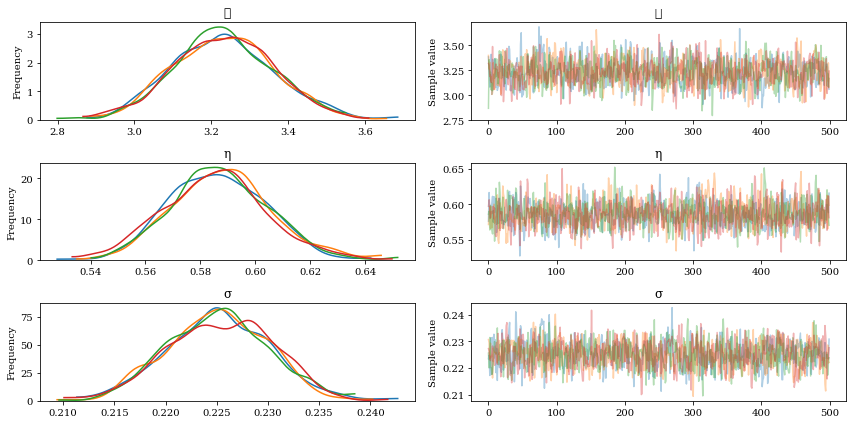

In [16]:
pm.plots.traceplot(dce_trace)
plt.show()

In [17]:
random_ints = np.random.randint(0,np.array(dce_mu_list).shape[0],1)
random_ints[0]

3535

In [18]:
ri = random_ints + 15
ri[0]

3550

In [19]:
def get_events2(mu_list, var_list, df):
    mask = np.array(mu_list).all(axis=1)
    events_mu = np.array(mu_list)[mask]
    events_var = np.array(var_list)[mask]
    
    events_gids = df['gid'].unique()[mask]
    
#     sub_events_mu = events_mu[0:15]
#     sub_events_var = events_var[0:15]
#     sub_events_gids = events_gids[0:15]
    
    
    random_ints = np.random.randint(0,events_mu.shape[0],1)
    random_ints15 = random_ints + 15


    sub_events_mu = events_mu[random_ints[0]:random_ints15[0]]
    sub_events_var = events_var[random_ints[0]:random_ints15[0]]
    sub_events_gids = events_gids[random_ints[0]:random_ints15[0]]
    
    return(sub_events_mu, sub_events_var, sub_events_gids)
# sub_events_mu, sub_events_var, sub_events_gids = get_events2(dce_mu_list, dce_var_list, df)

In [20]:
def plot_samples2(mp, mu_list, var_list, df, title, fig_title, ylab, unit):
    
    sub_events_mu, sub_events_var, sub_events_gids = get_events2(dce_mu_list, dce_var_list, df)
    
    fig = plt.figure(figsize=(13,5))

    colors = sns.color_palette("hls", 15)

    last_obs = 2012
    X = x_new
    y = sub_events_mu
    y_var = sub_events_var

    for i in np.arange(0,15):
        plt.plot(X,y[i], color = colors[i])
        plt.fill_between(X, y[i] + (y_var[i]*2), y[i] - (y_var[i]*2) , color = colors[i], alpha = 0.1)
        
        
        plt.scatter(X[:X.shape[0]-5],df[df['gid'] == sub_events_gids[i]]['sce_mu'], color = colors[i], alpha = 0.2, label = '')


    plt.vlines(last_obs,y.min()-1,y.max()*2, linestyles='--', color = 'gray', label='Last observed year = ' + str(last_obs))
    plt.fill_between(X[X>last_obs-1],y.min()-1,y.max()*2, color = 'gray', alpha = 0.1)#, label = '"consultable" forcastings')



    plt.vlines(last_obs +  mp['ℓ'],y.min()-1,y.max()*2, linestyles='-', color = 'salmon', 
               label='Last observed year + $\ell_{%s}$ ≈ %s' % (unit,str(int(last_obs+ mp['ℓ'][0].round(0))))) #old school to accomidate math

    plt.fill_between([last_obs+ mp['ℓ'][0],X.max()],y.min()-1,y.max()*2, color = 'red', alpha = 0.1)#, label = '"unconsultable" forcastings')

    plt.xticks(x_new, rotation=70, fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title(title, fontsize = 16)
    plt.xlabel('year', fontsize = 14)
    plt.ylabel(ylab, fontsize = 14)


    plt.ylim(-0.1,y.max()*2)
    plt.xlim(X.min(),X.max())

    plt.legend(fontsize = 12, loc = 0)
        
    #plt.text(1990,6,text, fontsize = 12)
    
    plt.savefig(fig_title + '.pdf', bbox_inches='tight')
    plt.show()

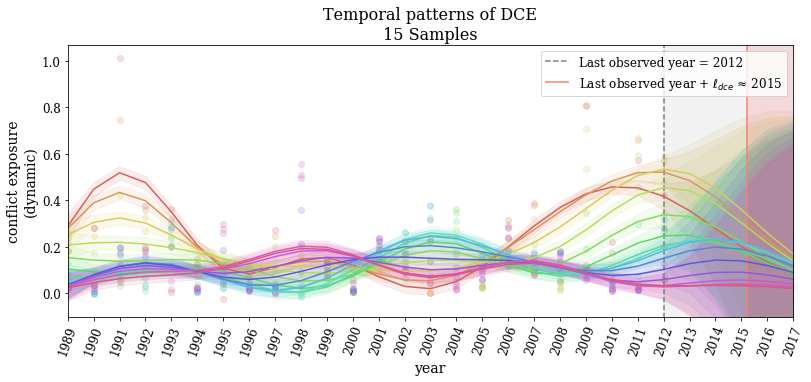

In [21]:
plot_samples2(dce_hp_mp_mu, dce_mu_list, dce_var_list, df,'Temporal patterns of DCE\n15 Samples', 'dce_15_samples', 'conflict exposure\n(dynamic)','dce')